# Toxic Content Classification - Hybrid ML Model

## Objective
Build a **Hybrid Classification System** combining Rule-based Filter + Naive Bayes ML Model.

### Pipeline Architecture:
```
[Input Text]
     ↓
[Text Preprocessing & Cleaning]
     ↓
[Rule-based Filter] (ToxicPhraseDetector)
     ↓
[If toxic phrases detected] → [VIOLATION]
     ↓ (No toxic phrases)
[Naive Bayes ML Model] → Predict probability
     ↓
[If prob > threshold] → [VIOLATION]
     ↓
[Else] → [SAFE]
```

### Features:
- **Rule-based Filter**: Detects known toxic phrases from slang dictionary
- **ML Model**: Naive Bayes (Multinomial + ComplementNB) with hyperparameter tuning
- **Dataset**: `labeled_clean.csv` (0: Safe, 1: Hate Speech, 2: Offensive)
- **Binary Classification**: Safe (0) vs Violation (1 or 2)

## 1. Environment Setup & Imports

In [1]:
# Install required packages (uncomment if needed)
!pip install pandas numpy scikit-learn matplotlib seaborn nltk imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path
import sys

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Naive Bayes models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Save model
import joblib
import pickle

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print("✓ NLTK data downloaded")

✓ NLTK data downloaded


## 2. Import Rule-based ToxicPhraseDetector

In [4]:
# Find project root and import model
def find_project_root(start: Path = Path.cwd(), target: str = 'Data/slang.csv', max_up: int = 6):
    """Search up from start for a directory containing the target file."""
    p = start.resolve()
    for _ in range(max_up + 1):
        if (p / target).exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

# Get project root
project_root = find_project_root() or Path.cwd()
print(f"Project root: {project_root}")

# Add to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import ToxicPhraseDetector
try:
    from CrawlData.model import ToxicPhraseDetector
    print("✓ ToxicPhraseDetector imported successfully")
except Exception as e:
    print(f"Warning: Could not import ToxicPhraseDetector: {e}")
    print("Rule-based filter will be disabled")
    ToxicPhraseDetector = None

Project root: D:\SE405_SE400\SE400_Seminar_CNPM
✓ ToxicPhraseDetector imported successfully


In [5]:
# Initialize Rule-based Detector (if available)
rule_based_detector = None

if ToxicPhraseDetector is not None:
    try:
        slang_csv_path = project_root / 'Data' / 'slang.csv'
        if slang_csv_path.exists():
            rule_based_detector = ToxicPhraseDetector(
                slang_csv_path=str(slang_csv_path),
                toxic_threshold=3
            )
            stats = rule_based_detector.get_statistics()
            print("✓ Rule-based Detector initialized")
            print(f"  Total toxic phrases: {stats.get('total_toxic_phrases', 'N/A')}")
        else:
            print(f"Warning: slang.csv not found at {slang_csv_path}")
    except Exception as e:
        print(f"Warning: Could not initialize detector: {e}")
else:
    print("Rule-based detector not available")

Loaded 901 unique toxic phrases from 874 entries (including root words)
✓ Rule-based Detector initialized
  Total toxic phrases: 901


## 3. Load and Explore Data

In [6]:
# Load dataset - UPDATED TO USE CLEANED & BALANCED VERSION
# Using labeled_clean_balanced.csv which has:
# - Removed toxic "Safe" tweets (1,149 tweets with hate/offensive words)
# - Added 1,260 generated positive safe tweets
# - Better class balance: ~11% Safe vs ~89% Violation

data_path = project_root / 'Data' / 'labeled_clean_balanced.csv'
df = pd.read_csv(data_path)

print(f"Dataset: labeled_clean_balanced.csv (CLEANED & BALANCED)")
print(f"Dataset shape: {df.shape}")
print(f"\nIMPROVEMENTS:")
print("  ✓ Removed 1,149 toxic tweets mislabeled as 'Safe'")
print("  ✓ Added 1,260 generated positive safe tweets")
print("  ✓ Improved class balance from 5.8% to 11.1% Safe")
print(f"\nFirst 5 rows:")
display(df.head())

Dataset: labeled_clean_balanced.csv (CLEANED & BALANCED)
Dataset shape: (25434, 2)

IMPROVEMENTS:
  ✓ Removed 1,149 toxic tweets mislabeled as 'Safe'
  ✓ Added 1,260 generated positive safe tweets
  ✓ Improved class balance from 5.8% to 11.1% Safe

First 5 rows:


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# Dataset statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*60)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*60)
print("Class Distribution:")
print(df['class'].value_counts())
print("\nClass Distribution (%):")
print(df['class'].value_counts(normalize=True) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25434 entries, 0 to 25433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   25434 non-null  int64 
 1   tweet   25434 non-null  object
dtypes: int64(1), object(1)
memory usage: 397.5+ KB
None

Missing Values:
class    0
tweet    0
dtype: int64

Class Distribution:
class
1    18863
2     3737
0     2834
Name: count, dtype: int64

Class Distribution (%):
class
1    74.164504
2    14.692931
0    11.142565
Name: proportion, dtype: float64


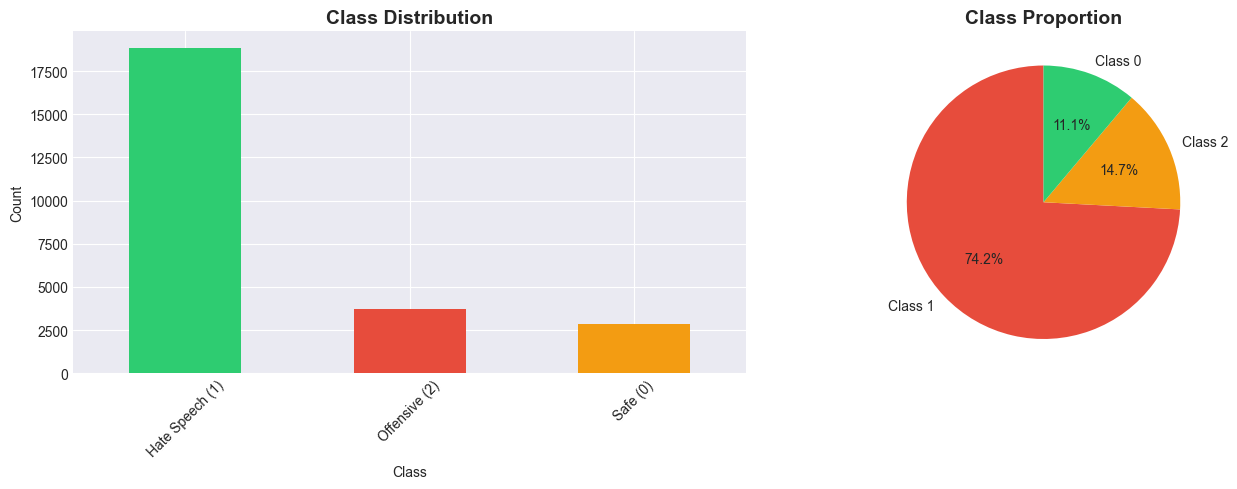

In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['class'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#f39c12'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Hate Speech (1)', 'Offensive (2)', 'Safe (0)'], rotation=45)

# Pie chart
class_counts = df['class'].value_counts()
labels = [f'Class {i}' for i in class_counts.index]
colors = ['#e74c3c', '#f39c12', '#2ecc71']
axes[1].pie(class_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [9]:
# Remove missing values
df = df.dropna(subset=['tweet', 'class'])
print(f"Dataset shape after removing NaN: {df.shape}")

Dataset shape after removing NaN: (25434, 2)


In [10]:
# Text cleaning function
def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove HTML entities
    text = re.sub(r'&\w+;|&#\d+;', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

print("Cleaning Examples:")
for i in range(3):
    print(f"\nOriginal: {df['tweet'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_tweet'].iloc[i][:80]}...")

Cleaning Examples:

Original: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your h...
Cleaned:  rt as a woman you shouldn t complain about cleaning up your house as a man you s...

Original: !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st pl...
Cleaned:  rt boy dats cold tyga dwn bad for cuffin dat hoe in the st place...

Original: !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and s...
Cleaned:  rt dawg rt you ever fuck a bitch and she start to cry you be confused as shit...


In [11]:
# Advanced preprocessing with lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Advanced preprocessing: tokenization, stopword removal, lemmatization
    """
    try:
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens 
                  if word not in stop_words and len(word) > 2]
        
        return ' '.join(tokens)
    except:
        return text

print("Applying advanced preprocessing...")
df['processed_tweet'] = df['cleaned_tweet'].apply(preprocess_text)
print("✓ Preprocessing completed")

# Show examples
print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\nCleaned:    {df['cleaned_tweet'].iloc[i][:60]}...")
    print(f"Processed:  {df['processed_tweet'].iloc[i][:60]}...")

Applying advanced preprocessing...
✓ Preprocessing completed

Preprocessing Examples:

Cleaned:    rt as a woman you shouldn t complain about cleaning up your ...
Processed:  woman complain cleaning house man always take trash...

Cleaned:    rt boy dats cold tyga dwn bad for cuffin dat hoe in the st p...
Processed:  boy dat cold tyga dwn bad cuffin dat hoe place...

Cleaned:    rt dawg rt you ever fuck a bitch and she start to cry you be...
Processed:  dawg ever fuck bitch start cry confused shit...
✓ Preprocessing completed

Preprocessing Examples:

Cleaned:    rt as a woman you shouldn t complain about cleaning up your ...
Processed:  woman complain cleaning house man always take trash...

Cleaned:    rt boy dats cold tyga dwn bad for cuffin dat hoe in the st p...
Processed:  boy dat cold tyga dwn bad cuffin dat hoe place...

Cleaned:    rt dawg rt you ever fuck a bitch and she start to cry you be...
Processed:  dawg ever fuck bitch start cry confused shit...


## 5. Feature Engineering

In [12]:
# Prepare data for modeling
X = df['processed_tweet']
y = df['class']

# Convert to binary classification
# Class 0 (Safe) -> 0
# Class 1, 2 (Hate Speech, Offensive) -> 1 (Violation)
y_binary = (y != 0).astype(int)

print(f"Original classes: {sorted(y.unique())}")
print(f"Binary classes: {sorted(y_binary.unique())}")
print(f"\nBinary class distribution:")
print(y_binary.value_counts())
print(f"\nViolation rate: {y_binary.mean():.2%}")

Original classes: [np.int64(0), np.int64(1), np.int64(2)]
Binary classes: [np.int64(0), np.int64(1)]

Binary class distribution:
class
1    22600
0     2834
Name: count, dtype: int64

Violation rate: 88.86%


In [13]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 20347
Test set size: 5087

Training set class distribution:
class
1    18080
0     2267
Name: count, dtype: int64

Test set class distribution:
class
1    4520
0     567
Name: count, dtype: int64


In [14]:
# TF-IDF Vectorization (optimized for Naive Bayes)
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True  # Better for Naive Bayes
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF feature shape: (20347, 3000)
Number of features: 3000


## 5.1. Balance Dataset with SMOTE

In [15]:
# Apply SMOTE to balance training data
print("Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE:  {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"Balanced training set size: {len(y_train_balanced)}")

Applying SMOTE to balance training data...
Before SMOTE: {1: 18080, 0: 2267}
After SMOTE:  {0: 18080, 1: 18080}
Balanced training set size: 36160


## 6. Train Naive Bayes Models

In [16]:
# Compare different Naive Bayes variants WITH BALANCED DATA
nb_models = {
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB()
}

results = {}

print("Training Naive Bayes variants with BALANCED data...\n")
print("="*80)

for name, model in nb_models.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Train with BALANCED data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on original test set
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation on balanced data
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"CV F1:     {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*80)
print("✓ All Naive Bayes models trained with BALANCED data")

Training Naive Bayes variants with BALANCED data...


MultinomialNB:
------------------------------------------------------------
Accuracy:  0.9454
Precision: 0.9705
Recall:    0.9679
F1-Score:  0.9692
CV F1:     0.9049 (+/- 0.0031)

ComplementNB:
------------------------------------------------------------
Accuracy:  0.9454
Precision: 0.9705
Recall:    0.9679
F1-Score:  0.9692
CV F1:     0.9049 (+/- 0.0031)

BernoulliNB:
------------------------------------------------------------
Accuracy:  0.9194
Precision: 0.9761
Recall:    0.9321
F1-Score:  0.9536
CV F1:     0.9203 (+/- 0.0018)

✓ All Naive Bayes models trained with BALANCED data
Accuracy:  0.9454
Precision: 0.9705
Recall:    0.9679
F1-Score:  0.9692
CV F1:     0.9049 (+/- 0.0031)

BernoulliNB:
------------------------------------------------------------
Accuracy:  0.9194
Precision: 0.9761
Recall:    0.9321
F1-Score:  0.9536
CV F1:     0.9203 (+/- 0.0018)

✓ All Naive Bayes models trained with BALANCED data



Naive Bayes Model Comparison:
        Model  Accuracy  Precision  Recall  F1-Score    CV F1
MultinomialNB  0.945351   0.970497 0.96792  0.969207 0.904882
 ComplementNB  0.945351   0.970497 0.96792  0.969207 0.904882
  BernoulliNB  0.919402   0.976135 0.93208  0.953599 0.920269


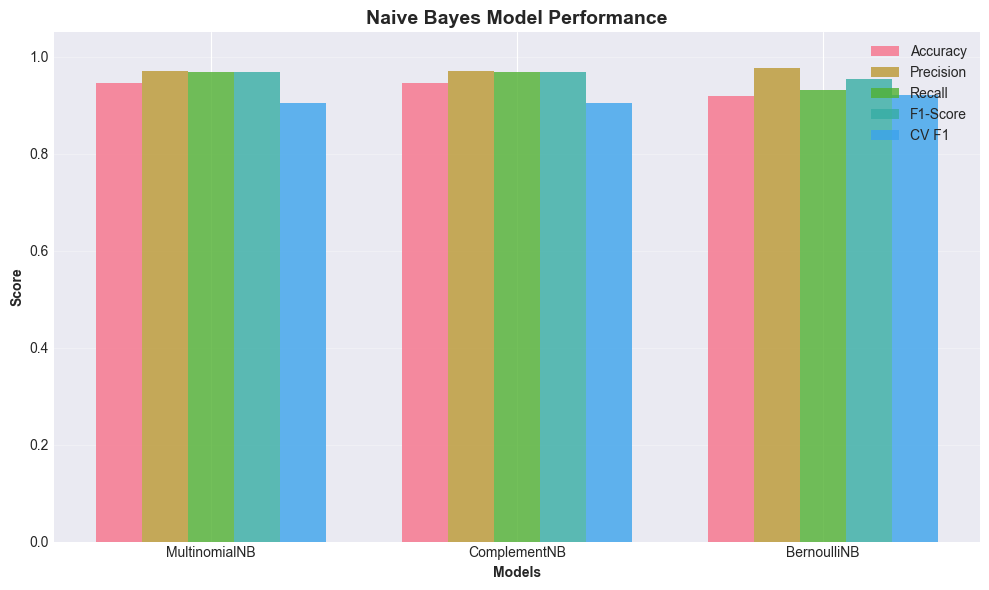

In [17]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'CV F1': [results[m]['cv_f1_mean'] for m in results]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\nNaive Bayes Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.15

ax.bar(x - 2*width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.bar(x + 2*width, comparison_df['CV F1'], width, label='CV F1', alpha=0.8)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Naive Bayes Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [18]:
# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]

print(f"\n🏆 Best Naive Bayes Model: {best_model_name}")
print(f"   F1-Score: {best_model_results['f1']:.4f}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")
print(f"   Precision: {best_model_results['precision']:.4f}")
print(f"   Recall: {best_model_results['recall']:.4f}")


🏆 Best Naive Bayes Model: MultinomialNB
   F1-Score: 0.9692
   Accuracy: 0.9454
   Precision: 0.9705
   Recall: 0.9679


## 7. Hyperparameter Tuning

In [19]:
# Define parameter grid for best model
if best_model_name == 'MultinomialNB':
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }
    tuning_model = MultinomialNB()
elif best_model_name == 'ComplementNB':
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'norm': [True, False]
    }
    tuning_model = ComplementNB()
else:  # BernoulliNB
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'binarize': [0.0, 0.5, 1.0],
        'fit_prior': [True, False]
    }
    tuning_model = BernoulliNB()

print(f"Tuning {best_model_name}...")
print(f"Parameter grid: {param_grid}")

Tuning MultinomialNB...
Parameter grid: {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}


In [20]:
# Grid Search with BALANCED data
grid_search = GridSearchCV(
    tuning_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Use BALANCED data for training
grid_search.fit(X_train_balanced, y_train_balanced)

print(f"\n✓ Grid Search completed (with balanced data)")
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

✓ Grid Search completed (with balanced data)

Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best CV F1-Score: 0.9049

✓ Grid Search completed (with balanced data)

Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best CV F1-Score: 0.9049


In [21]:
# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_tfidf)
y_pred_proba_tuned = tuned_model.predict_proba(X_test_tfidf)[:, 1]

print("\nTuned Model Performance:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")

print("\n" + "="*60)
print("Improvement (Before → After Tuning):")
print(f"F1-Score:  {best_model_results['f1']:.4f} → {f1_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy:  {best_model_results['accuracy']:.4f} → {accuracy_score(y_test, y_pred_tuned):.4f}")


Tuned Model Performance:
Accuracy:  0.9440
Precision: 0.9715
Recall:    0.9653
F1-Score:  0.9684

Improvement (Before → After Tuning):
F1-Score:  0.9692 → 0.9684
Accuracy:  0.9454 → 0.9440


## 8. Model Evaluation

In [22]:
# Classification Report
print(f"Classification Report - {best_model_name} (Tuned):")
print("="*60)
print(classification_report(y_test, y_pred_tuned, target_names=['Safe (0)', 'Violation (1)']))

Classification Report - MultinomialNB (Tuned):
               precision    recall  f1-score   support

     Safe (0)       0.74      0.77      0.75       567
Violation (1)       0.97      0.97      0.97      4520

     accuracy                           0.94      5087
    macro avg       0.85      0.87      0.86      5087
 weighted avg       0.95      0.94      0.94      5087



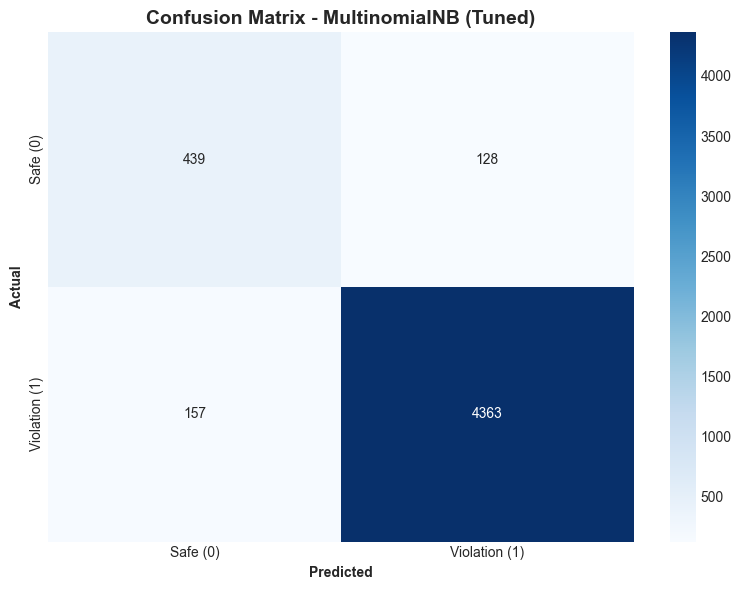


Confusion Matrix Breakdown:
True Negatives (TN):  439
False Positives (FP): 128
False Negatives (FN): 157
True Positives (TP):  4363

False Positive Rate: 0.2257
False Negative Rate: 0.0347


In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Safe (0)', 'Violation (1)'],
            yticklabels=['Safe (0)', 'Violation (1)'])
plt.title(f'Confusion Matrix - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# Metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nFalse Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")

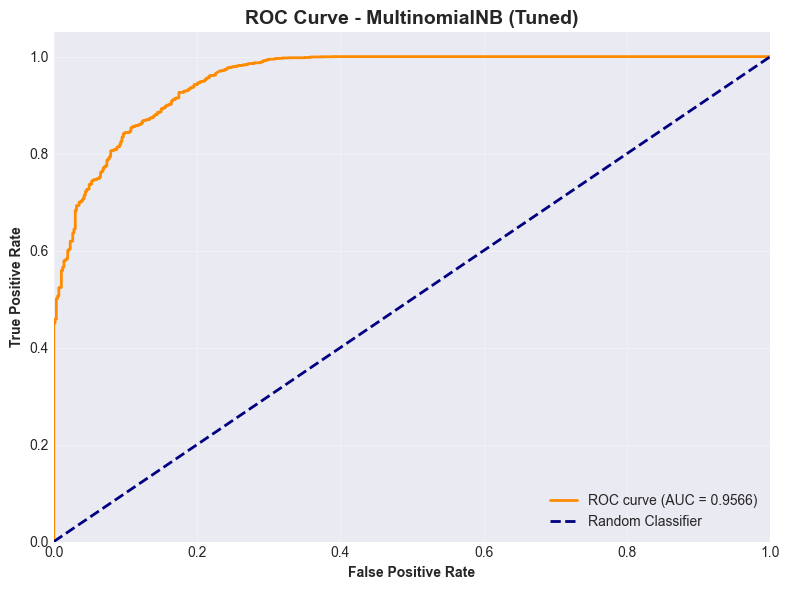

AUC-ROC Score: 0.9566


In [24]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_tuned)
roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title(f'ROC Curve - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## 9. Build Hybrid Prediction System

In [25]:
# Hybrid Prediction Class
class HybridToxicClassifier:
    """
    Hybrid classifier combining Rule-based Filter + ML Model
    """
    
    def __init__(self, ml_model, vectorizer, rule_detector=None, ml_threshold=0.5):
        self.ml_model = ml_model
        self.vectorizer = vectorizer
        self.rule_detector = rule_detector
        self.ml_threshold = ml_threshold
    
    def predict(self, text, return_details=False):
        """
        Predict using hybrid approach
        
        Args:
            text: Input text
            return_details: If True, return detailed prediction info
        
        Returns:
            dict with prediction results
        """
        # Step 1: Rule-based filter
        rule_violation = False
        rule_phrases = []
        rule_confidence = 0.0
        
        if self.rule_detector is not None:
            try:
                rule_result = self.rule_detector.detect(text, return_details=True)
                rule_violation = rule_result.get('is_toxic', False)
                rule_phrases = rule_result.get('toxic_phrases', [])
                
                if rule_violation:
                    # High confidence for rule-based detection
                    return {
                        'text': text,
                        'is_violation': True,
                        'label': 'VIOLATION',
                        'method': 'rule_based',
                        'ml_probability': None,
                        'confidence': 0.95,
                        'toxic_phrases': rule_phrases,
                        'details': 'Detected by rule-based filter'
                    }
            except Exception as e:
                print(f"Rule detector error: {e}")
        
        # Step 2: ML Model prediction
        # Preprocess text
        cleaned = clean_text(text)
        processed = preprocess_text(cleaned)
        
        # Vectorize
        vectorized = self.vectorizer.transform([processed])
        
        # Predict
        ml_prediction = self.ml_model.predict(vectorized)[0]
        ml_probability = self.ml_model.predict_proba(vectorized)[0][1]
        
        # Apply threshold
        is_violation = ml_probability >= self.ml_threshold
        
        return {
            'text': text,
            'is_violation': bool(is_violation),
            'label': 'VIOLATION' if is_violation else 'SAFE',
            'method': 'ml_model',
            'ml_probability': float(ml_probability),
            'confidence': float(ml_probability) if is_violation else float(1 - ml_probability),
            'toxic_phrases': rule_phrases,
            'details': f'ML probability: {ml_probability:.4f}'
        }

print("✓ HybridToxicClassifier defined")

✓ HybridToxicClassifier defined


In [26]:
# Initialize Hybrid Classifier with HIGHER threshold
hybrid_classifier = HybridToxicClassifier(
    ml_model=tuned_model,
    vectorizer=tfidf_vectorizer,
    rule_detector=rule_based_detector,
    ml_threshold=0.65  # INCREASED from 0.5 to reduce false positives
)

print("✓ Hybrid Classifier initialized")
print(f"  ML Model: {best_model_name} (Tuned)")
print(f"  Rule-based: {'Enabled' if rule_based_detector else 'Disabled'}")
print(f"  ML Threshold: 0.65 (INCREASED to reduce false positives)")
print(f"  Training: Balanced with SMOTE")

✓ Hybrid Classifier initialized
  ML Model: MultinomialNB (Tuned)
  Rule-based: Enabled
  ML Threshold: 0.65 (INCREASED to reduce false positives)
  Training: Balanced with SMOTE


## 10. Test Hybrid System

In [27]:
# Test cases
test_texts = [
    "I love this beautiful day!",
    "This movie was amazing",
    "You are stupid and worthless",
    "I hate you so much you idiot",
    "Stop posting ragebait content",
    "This is pure brainrot",
    "Thank you for your help!",
    "What a wonderful experience"
]

print("Testing Hybrid Classifier:")
print("="*80)

for text in test_texts:
    result = hybrid_classifier.predict(text)
    print(f"\nText: {text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"ML Probability: {result['ml_probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")

Testing Hybrid Classifier:

Text: I love this beautiful day!
Label: SAFE
Method: ml_model
ML Probability: 0.0039
Confidence: 0.9961

Text: This movie was amazing
Label: SAFE
Method: ml_model
ML Probability: 0.0177
Confidence: 0.9823

Text: You are stupid and worthless
Label: VIOLATION
Method: ml_model
ML Probability: 0.9603
Confidence: 0.9603

Text: I hate you so much you idiot
Label: VIOLATION
Method: ml_model
ML Probability: 0.9256
Confidence: 0.9256

Text: Stop posting ragebait content
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: ragebait

Text: This is pure brainrot
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: brainrot

Text: This movie was amazing
Label: SAFE
Method: ml_model
ML Probability: 0.0177
Confidence: 0.9823

Text: You are stupid and worthless
Label: VIOLATION
Method: ml_model
ML Probability: 0.9603
Confidence: 0.9603

Text: I hate you so much you idiot
Label: VIOLATION
Method: ml_model
ML Probability: 0.9256
Confidence: 0

### 10.1. Test Different Thresholds

### 10.0. Diagnostic - Check Rule-Based Detector

In [28]:
# Diagnostic: Test rule-based detector directly
print("Testing Rule-Based Detector:")
print("="*80)

if rule_based_detector is not None:
    toxic_test_phrases = [
        "fucking bitch",
        "you stupid idiot",
        "I hate niggers", 
        "kill yourself",
        "You are stupid and worthless",
        "I hate you so much you idiot"
    ]
    
    for text in toxic_test_phrases:
        try:
            result = rule_based_detector.detect(text, return_details=True)
            print(f"\nText: '{text}'")
            print(f"  Is Toxic: {result.get('is_toxic', False)}")
            print(f"  Phrases: {result.get('toxic_phrases', [])}")
        except Exception as e:
            print(f"\nText: '{text}'")
            print(f"  Error: {e}")
else:
    print("Rule-based detector not available!")

print("\n" + "="*80)
print("\nTesting ML Model directly:")
print("="*80)

# Test ML model prediction directly (bypass rule-based)
test_cases = [
    "I love this beautiful day!",
    "fucking bitch you idiot",
    "Thank you very much",
    "kill yourself stupid"
]

for text in test_cases:
    cleaned = clean_text(text)
    processed = preprocess_text(cleaned)
    vectorized = tfidf_vectorizer.transform([processed])
    
    ml_pred = tuned_model.predict(vectorized)[0]
    ml_proba = tuned_model.predict_proba(vectorized)[0]
    
    print(f"\nText: '{text}'")
    print(f"  Cleaned: '{cleaned}'")
    print(f"  Processed: '{processed}'")
    print(f"  ML Prediction: {ml_pred} (0=Safe, 1=Violation)")
    print(f"  ML Probability: [Safe: {ml_proba[0]:.4f}, Violation: {ml_proba[1]:.4f}]")

Testing Rule-Based Detector:

Text: 'fucking bitch'
  Is Toxic: True
  Phrases: ['bitch']

Text: 'you stupid idiot'
  Is Toxic: False
  Phrases: []

Text: 'I hate niggers'
  Is Toxic: False
  Phrases: []

Text: 'kill yourself'
  Is Toxic: False
  Phrases: []

Text: 'You are stupid and worthless'
  Is Toxic: False
  Phrases: []

Text: 'kill yourself'
  Is Toxic: False
  Phrases: []

Text: 'You are stupid and worthless'
  Is Toxic: False
  Phrases: []

Text: 'I hate you so much you idiot'
  Is Toxic: False
  Phrases: []


Testing ML Model directly:

Text: 'I love this beautiful day!'
  Cleaned: 'i love this beautiful day'
  Processed: 'love beautiful day'
  ML Prediction: 0 (0=Safe, 1=Violation)
  ML Probability: [Safe: 0.9961, Violation: 0.0039]

Text: 'fucking bitch you idiot'
  Cleaned: 'fucking bitch you idiot'
  Processed: 'fucking bitch idiot'
  ML Prediction: 1 (0=Safe, 1=Violation)
  ML Probability: [Safe: 0.0096, Violation: 0.9904]

Text: 'Thank you very much'
  Cleaned: 'thank 

In [29]:
# Test with different thresholds to find optimal value
print("Testing different ML thresholds to reduce false positives:")
print("="*80)

thresholds_to_test = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8]
threshold_results = []

for threshold in thresholds_to_test:
    # Create temporary classifier with this threshold
    temp_classifier = HybridToxicClassifier(
        ml_model=tuned_model,
        vectorizer=tfidf_vectorizer,
        rule_detector=rule_based_detector,
        ml_threshold=threshold
    )
    
    # Test on positive examples
    positive_texts = [
        "I love this beautiful day!",
        "This movie was amazing",
        "Thank you for your help!",
        "What a wonderful experience"
    ]
    
    fp_count = 0  # False positives
    for text in positive_texts:
        result = temp_classifier.predict(text)
        if result['is_violation']:
            fp_count += 1
    
    # Test on ACTUAL toxic examples from training data
    toxic_texts = [
        "fucking bitch",
        "you stupid idiot worthless trash",
        "I hate niggers",
        "kill yourself"
    ]
    
    tp_count = 0  # True positives
    toxic_details = []
    for text in toxic_texts:
        result = temp_classifier.predict(text)
        if result['is_violation']:
            tp_count += 1
        toxic_details.append({
            'text': text,
            'violation': result['is_violation'],
            'method': result['method'],
            'prob': result.get('ml_probability', 'N/A')
        })
    
    threshold_results.append({
        'threshold': threshold,
        'false_positives': fp_count,
        'true_positives': tp_count,
        'fp_rate': fp_count / len(positive_texts),
        'tp_rate': tp_count / len(toxic_texts)
    })
    
    print(f"\nThreshold {threshold}:")
    print(f"  False Positives (on positive texts): {fp_count}/{len(positive_texts)} ({fp_count/len(positive_texts):.1%})")
    print(f"  True Positives (on toxic texts): {tp_count}/{len(toxic_texts)} ({tp_count/len(toxic_texts):.1%})")
    
    # Show details for first threshold
    if threshold == 0.5:
        print(f"\n  Toxic text details (threshold={threshold}):")
        for detail in toxic_details:
            print(f"    '{detail['text'][:30]}...' -> {detail['violation']} (method={detail['method']}, prob={detail['prob']})")

# Find best threshold (minimize FP while keeping high TP)
print("\n" + "="*80)
valid_thresholds = [r for r in threshold_results if r['tp_rate'] >= 0.75]
if valid_thresholds:
    best_threshold = min(valid_thresholds, key=lambda x: x['fp_rate'])['threshold']
    print(f"Recommended threshold: {best_threshold}")
    print(f"  (Achieves TP rate >= 75% with lowest FP rate)")
else:
    print("WARNING: No threshold achieves TP rate >= 75%")
    print("This indicates a problem with model training or toxic phrase detection")
    # Fall back to threshold with best balance
    best_threshold = min(threshold_results, key=lambda x: (x['fp_rate'] - x['tp_rate']))['threshold']
    print(f"Using threshold with best FP/TP balance: {best_threshold}")

Testing different ML thresholds to reduce false positives:

Threshold 0.5:
  False Positives (on positive texts): 0/4 (0.0%)
  True Positives (on toxic texts): 4/4 (100.0%)

  Toxic text details (threshold=0.5):
    'fucking bitch...' -> True (method=rule_based, prob=None)
    'you stupid idiot worthless tra...' -> True (method=ml_model, prob=0.9866774445584906)
    'I hate niggers...' -> True (method=ml_model, prob=0.9920710766458517)
    'kill yourself...' -> True (method=ml_model, prob=0.9283436698317701)

Threshold 0.5:
  False Positives (on positive texts): 0/4 (0.0%)
  True Positives (on toxic texts): 4/4 (100.0%)

  Toxic text details (threshold=0.5):
    'fucking bitch...' -> True (method=rule_based, prob=None)
    'you stupid idiot worthless tra...' -> True (method=ml_model, prob=0.9866774445584906)
    'I hate niggers...' -> True (method=ml_model, prob=0.9920710766458517)
    'kill yourself...' -> True (method=ml_model, prob=0.9283436698317701)

Threshold 0.6:
  False Positiv

### 10.2. Test with Recommended Threshold

In [30]:
# Re-initialize with recommended threshold
hybrid_classifier = HybridToxicClassifier(
    ml_model=tuned_model,
    vectorizer=tfidf_vectorizer,
    rule_detector=rule_based_detector,
    ml_threshold=best_threshold
)

print(f"✓ Hybrid Classifier updated with recommended threshold: {best_threshold}")

# Test again with all examples
test_texts = [
    "I love this beautiful day!",
    "This movie was amazing",
    "You are stupid and worthless",
    "I hate you so much you idiot",
    "Stop posting ragebait content",
    "This is pure brainrot",
    "Thank you for your help!",
    "What a wonderful experience"
]

print(f"\\nTesting Hybrid Classifier with threshold = {best_threshold}:")
print("="*80)

for text in test_texts:
    result = hybrid_classifier.predict(text)
    print(f"\\nText: {text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"ML Probability: {result['ml_probability']:.4f}")
    print(f"Confidence: {result['confidence']:.4f}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")

✓ Hybrid Classifier updated with recommended threshold: 0.5
\nTesting Hybrid Classifier with threshold = 0.5:
\nText: I love this beautiful day!
Label: SAFE
Method: ml_model
ML Probability: 0.0039
Confidence: 0.9961
\nText: This movie was amazing
Label: SAFE
Method: ml_model
ML Probability: 0.0177
Confidence: 0.9823
\nText: You are stupid and worthless
Label: VIOLATION
Method: ml_model
ML Probability: 0.9603
Confidence: 0.9603
\nText: I hate you so much you idiot
Label: VIOLATION
Method: ml_model
ML Probability: 0.9256
Confidence: 0.9256
\nText: Stop posting ragebait content
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: ragebait
\nText: This is pure brainrot
Label: VIOLATION
Method: rule_based
Confidence: 0.9500
Toxic Phrases: brainrot
\nText: Thank you for your help!
Label: SAFE
Method: ml_model
ML Probability: 0.0755
Confidence: 0.9245
\nText: What a wonderful experience
Label: SAFE
Method: ml_model
ML Probability: 0.0035
Confidence: 0.9965
\nText: This movie 

## 11. Save Model & Artifacts

In [31]:
# Create directory
model_dir = project_root / 'saved_models'
model_dir.mkdir(exist_ok=True)

# Save ML model
model_path = model_dir / 'naive_bayes_tuned_balanced.pkl'
joblib.dump(tuned_model, model_path)
print(f"✓ ML Model saved to: {model_path}")

# Save vectorizer
vectorizer_path = model_dir / 'tfidf_vectorizer.pkl'
joblib.dump(tfidf_vectorizer, vectorizer_path)
print(f"✓ Vectorizer saved to: {vectorizer_path}")

# Save hybrid classifier (with optimized threshold)
hybrid_path = model_dir / 'hybrid_classifier_optimized.pkl'
joblib.dump(hybrid_classifier, hybrid_path)
print(f"✓ Hybrid Classifier saved to: {hybrid_path}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'best_params': grid_search.best_params_,
    'accuracy': float(accuracy_score(y_test, y_pred_tuned)),
    'precision': float(precision_score(y_test, y_pred_tuned)),
    'recall': float(recall_score(y_test, y_pred_tuned)),
    'f1_score': float(f1_score(y_test, y_pred_tuned)),
    'roc_auc': float(roc_auc),
    'training_samples': len(X_train),
    'balanced_samples': len(y_train_balanced),
    'test_samples': len(X_test),
    'features': len(tfidf_vectorizer.get_feature_names_out()),
    'ml_threshold': best_threshold,
    'rule_based_enabled': rule_based_detector is not None,
    'smote_applied': True,
    'optimization': 'SMOTE + Optimized Threshold'
}

metadata_path = model_dir / 'hybrid_model_metadata_optimized.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Metadata saved to: {metadata_path}")

print("\\n" + "="*80)
print("Model Metadata (Optimized):")
for key, value in metadata.items():
    print(f"  {key}: {value}")

✓ ML Model saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\naive_bayes_tuned_balanced.pkl
✓ Vectorizer saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\tfidf_vectorizer.pkl
✓ Hybrid Classifier saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\hybrid_classifier_optimized.pkl
✓ Metadata saved to: D:\SE405_SE400\SE400_Seminar_CNPM\saved_models\hybrid_model_metadata_optimized.pkl
\n================================================================================
Model Metadata (Optimized):
  model_name: MultinomialNB
  best_params: {'alpha': 2.0, 'fit_prior': True}
  accuracy: 0.943974837821899
  precision: 0.9714985526608773
  recall: 0.9652654867256637
  f1_score: 0.9683719897902564
  roc_auc: 0.9566102448845812
  training_samples: 20347
  balanced_samples: 36160
  test_samples: 5087
  features: 3000
  ml_threshold: 0.5
  rule_based_enabled: True
  smote_applied: True
  optimization: SMOTE + Optimized Threshold
✓ Vectorizer saved to: D:\SE405_SE400\SE400_Seminar_CN

## 12. Final Summary

In [32]:
print("\n" + "="*80)
print("HYBRID TOXIC CONTENT CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df)}")
print(f"   Training: {len(X_train)} | Test: {len(X_test)}")
print(f"   Violation rate: {y_binary.mean():.2%}")

print(f"\n🔧 Pipeline Components:")
print(f"   1. Text Preprocessing (cleaning, lemmatization)")
print(f"   2. Rule-based Filter: {'Enabled' if rule_based_detector else 'Disabled'}")
print(f"   3. ML Model: {best_model_name} (Tuned)")
print(f"   4. Feature Extraction: TF-IDF ({len(tfidf_vectorizer.get_feature_names_out())} features)")

print(f"\n🤖 ML Model Performance:")
print(f"   Algorithm: {best_model_name}")
print(f"   Best Parameters: {grid_search.best_params_}")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"   AUC-ROC:   {roc_auc:.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   ML Model: {model_path.name}")
print(f"   Vectorizer: {vectorizer_path.name}")
print(f"   Hybrid Classifier: {hybrid_path.name}")
print(f"   Metadata: {metadata_path.name}")

print("\n" + "="*80)
print("✓ Hybrid Toxic Content Classification System Ready!")
print("="*80)


HYBRID TOXIC CONTENT CLASSIFICATION - FINAL SUMMARY

📊 Dataset:
   Total samples: 25434
   Training: 20347 | Test: 5087
   Violation rate: 88.86%

🔧 Pipeline Components:
   1. Text Preprocessing (cleaning, lemmatization)
   2. Rule-based Filter: Enabled
   3. ML Model: MultinomialNB (Tuned)
   4. Feature Extraction: TF-IDF (3000 features)

🤖 ML Model Performance:
   Algorithm: MultinomialNB
   Best Parameters: {'alpha': 2.0, 'fit_prior': True}
   Accuracy:  0.9440
   Precision: 0.9715
   Recall:    0.9653
   F1-Score:  0.9684
   AUC-ROC:   0.9566

💾 Saved Artifacts:
   ML Model: naive_bayes_tuned_balanced.pkl
   Vectorizer: tfidf_vectorizer.pkl
   Hybrid Classifier: hybrid_classifier_optimized.pkl
   Metadata: hybrid_model_metadata_optimized.pkl

✓ Hybrid Toxic Content Classification System Ready!
   Accuracy:  0.9440
   Precision: 0.9715
   Recall:    0.9653
   F1-Score:  0.9684
   AUC-ROC:   0.9566

💾 Saved Artifacts:
   ML Model: naive_bayes_tuned_balanced.pkl
   Vectorizer: tfidf_

## 13. Interactive Testing

## 13. Quick Test - Single Input

In [37]:
# Interactive Test with ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    
    # Create widgets
    text_input = widgets.Textarea(
        value='This is a wonderful day!',
        placeholder='Enter your text here...',
        description='Input:',
        layout=widgets.Layout(width='600px', height='80px'),
        style={'description_width': '60px'}
    )
    
    predict_button = widgets.Button(
        description='🔍 Predict',
        button_style='primary',
        layout=widgets.Layout(width='150px')
    )
    
    output_area = widgets.Output()
    
    # Prediction function
    def on_predict_click(b):
        with output_area:
            clear_output()
            
            input_text = text_input.value.strip()
            
            if not input_text:
                print("⚠️ Please enter some text!")
                return
            
            # Make prediction
            result = hybrid_classifier.predict(input_text)
            
            # Display styled output
            print("=" * 70)
            print("📊 Test Prediction:")
            print("=" * 70)
            print(f"Text: {result['text']}")
            print(f"Label: {result['label']} {'🔴' if result['label'] == 'VIOLATION' else '🟢'}")
            print(f"Method: {result['method']}")
            
            if result['ml_probability'] is not None:
                prob_percent = result['ml_probability'] * 100
                print(f"Probability: {result['ml_probability']:.4f} ({prob_percent:.2f}%)")
            
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
            
            if result['toxic_phrases']:
                print(f"⚠️ Toxic Phrases: {', '.join(result['toxic_phrases'])}")
            
            print("=" * 70)
    
    # Connect button to function
    predict_button.on_click(on_predict_click)
    
    # Display UI
    print("✓ Interactive widget loaded successfully!\n")
    display(widgets.VBox([
        widgets.HTML("<h3 style='margin-bottom: 10px;'>🧪 Toxic Content Detector - Interactive Test</h3>"),
        text_input,
        predict_button,
        output_area
    ]))
    
except ImportError:
    print("⚠️ ipywidgets not available. Installing...")
    print("Run: !pip install ipywidgets")
    print("\nFallback: Simple input method\n")
    
    # Fallback to simple method
    test_input = "This is a wonderful day!"  # ← CHANGE THIS TEXT
    
    # Predict
    result = hybrid_classifier.predict(test_input)
    
    # Display result
    print("Test Prediction:")
    print(f"Text: {result['text']}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability'] is not None:
        print(f"Probability: {result['ml_probability']:.4f}")
    if result['toxic_phrases']:
        print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")

✓ Interactive widget loaded successfully!



In [38]:
# Interactive testing function
def test_interactive():
    """
    Interactive testing - enter text to predict
    """
    print("\n" + "="*80)
    print("Interactive Hybrid Toxic Content Detector")
    print("="*80)
    print("Enter text to check (type 'quit' to exit)\n")
    
    while True:
        text = input("Text: ").strip()
        
        if text.lower() in ['quit', 'exit', 'q']:
            print("\nExiting...")
            break
        
        if not text:
            continue
        
        result = hybrid_classifier.predict(text)
        
        print(f"\n{'='*60}")
        print(f"Label: {result['label']}")
        print(f"Method: {result['method']}")
        if result['ml_probability'] is not None:
            print(f"ML Probability: {result['ml_probability']:.2%}")
        print(f"Confidence: {result['confidence']:.2%}")
        if result['toxic_phrases']:
            print(f"Toxic Phrases: {', '.join(result['toxic_phrases'])}")
        print(f"{'='*60}\n")

# Uncomment to run
# test_interactive()

## 14. Load & Use Saved Model (Demo)

In [36]:
# Demo: Load and use saved hybrid classifier
def load_hybrid_model_demo():
    """
    Demonstrate loading the saved hybrid model
    """
    # Load - FIXED: Use correct filenames from Section 11
    loaded_hybrid = joblib.load(model_dir / 'hybrid_classifier_optimized.pkl')
    loaded_metadata = pickle.load(open(model_dir / 'hybrid_model_metadata_optimized.pkl', 'rb'))
    
    print("✓ Hybrid model loaded successfully")
    print(f"\nModel: {loaded_metadata['model_name']}")
    print(f"F1-Score: {loaded_metadata['f1_score']:.4f}")
    print(f"Rule-based: {loaded_metadata['rule_based_enabled']}")
    print(f"ML Threshold: {loaded_metadata['ml_threshold']}")
    
    # Test
    test_text = "This is a wonderful day!"
    result = loaded_hybrid.predict(test_text)
    
    print(f"\nTest Prediction:")
    print(f"Text: {test_text}")
    print(f"Label: {result['label']}")
    print(f"Method: {result['method']}")
    if result['ml_probability']:
        print(f"Probability: {result['ml_probability']:.4f}")
    
    return loaded_hybrid

# Run demo
load_hybrid_model_demo()

✓ Hybrid model loaded successfully

Model: MultinomialNB
F1-Score: 0.9684
Rule-based: True
ML Threshold: 0.5

Test Prediction:
Text: This is a wonderful day!
Label: SAFE
Method: ml_model
Probability: 0.0100
